In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
import pandas as pd
import numpy as np

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, isnan, when
# 初始化Spark会话
spark = SparkSession.builder \
    .appName('722') \
    .config('spark.sql.debug.maxToStringFields', '1000') \
    .getOrCreate()


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/22 04:49:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


2.2 Describe the data

In [6]:
# 加载CSV数据
hospital = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("hospital distribution.csv")
clients_data = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("clients.csv")
education = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("Education.csv")
income = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("Income dataset.csv")
life = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("life expectancy.csv")

In [7]:
# 描述数据集的函数
def describe_data(df, name):
    print(f"Dataset Name: {name}")
    print(f"Format: CSV")
    print(f"Number of Rows: {df.count()}")
    print(f"Number of Columns: {len(df.columns)}")
    print("\nFields and Data Types:")
    df.printSchema()
    print("\nSample Data:")
    df.show(5)
    print("\nMissing Values (%):")
    missing_values = df.select([(count(when(col(c).isNull() | isnan(c), c)) / df.count() * 100).alias(c) for c in df.columns])
    missing_values.show()
    print("\n")


In [8]:
# 调用函数描述每个数据集
describe_data(hospital, "Hospital Distribution")

Dataset Name: Hospital Distribution
Format: CSV
Number of Rows: 71
Number of Columns: 28

Fields and Data Types:
root
 |-- Premises_Name: string (nullable = true)
 |-- Certification_Service_Type: string (nullable = true)
 |-- Service_Types: string (nullable = true)
 |-- Total_Beds: integer (nullable = true)
 |-- Premises_Website: string (nullable = true)
 |-- Premises_Address_Other: string (nullable = true)
 |-- Premises_Address: string (nullable = true)
 |-- Premises_Address_Suburb_Road: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Premises_Address_Post_Code: integer (nullable = true)
 |-- DHB_Name: string (nullable = true)
 |-- Certificate_Name: string (nullable = true)
 |-- Certification_Period__Months_: string (nullable = true)
 |-- Certificate_License_End_Date: string (nullable = true)
 |-- Current_Auditor: string (nullable = true)
 |-- Legal_Name: string (nullable = true)
 |-- Legal_Entity_Address_Other: string (nullable = true)
 |-- Legal_Entity_Address: str

In [9]:
# 检测Total_Beds字段中的异常值
if 'Total_Beds' in hospital.columns:
    Q1 = hospital.approxQuantile("Total_Beds", [0.25], 0.0)[0]
    Q3 = hospital.approxQuantile("Total_Beds", [0.75], 0.0)[0]
    IQR = Q3 - Q1
    outliers = hospital.filter((col("Total_Beds") < (Q1 - 1.5 * IQR)) | (col("Total_Beds") > (Q3 + 1.5 * IQR)))
    total_beds_outliers_percentage = outliers.count() / hospital.count() * 100
else:
    outliers = None
    total_beds_outliers_percentage = None

print(f"Percentage of outliers in Total_Beds: {total_beds_outliers_percentage}%")
if outliers is not None:
    outliers.show()

describe_data(clients_data, "Clients Data")

Percentage of outliers in Total_Beds: 12.676056338028168%
+--------------------+--------------------------+--------------------+----------+----------------+----------------------+--------------------+----------------------------+------------+--------------------------+--------------------+--------------------+-----------------------------+----------------------------+--------------------+--------------------+--------------------------+--------------------+-------------------------------+------------------------------+------------------------------+---------------------------+-------------------------------+-------------------------------+-------------------------------+--------------------+--------+-------------+
|       Premises_Name|Certification_Service_Type|       Service_Types|Total_Beds|Premises_Website|Premises_Address_Other|    Premises_Address|Premises_Address_Suburb_Road|        City|Premises_Address_Post_Code|            DHB_Name|    Certificate_Name|Certification_Period__Mo

Number of Rows: 1220
Number of Columns: 6

Fields and Data Types:
root
 |-- count: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- destination: string (nullable = true)
 |-- amount: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- Key: integer (nullable = true)


Sample Data:
+-----+-------------+-----------+------+----+---+
|count|       Region|destination|amount|year|Key|
+-----+-------------+-----------+------+----+---+
|    1|    Northland|  Northland|  5978|2015|  1|
|    3|     Auckland|  Northland|   132|2015|  1|
|    5|      Waikato|  Northland|    75|2015|  1|
|    7|Bay of Plenty|  Northland|    36|2015|  1|
|    9|     Taranaki|  Northland|    15|2015|  1|
+-----+-------------+-----------+------+----+---+
only showing top 5 rows


Missing Values (%):
+-----+------+-----------+-----------------+------------------+------------------+
|count|Region|destination|           amount|              year|               Key|
+-----+------+--------

In [10]:
# 检测clients_data中amount字段的异常值
if 'amount' in clients_clean.columns:
    Q1 = clients_data.approxQuantile("amount", [0.25], 0.0)[0]
    Q3 = clients_data.approxQuantile("amount", [0.75], 0.0)[0]
    IQR = Q3 - Q1
    outliers = clients_data.filter((col("amount") < (Q1 - 1.5 * IQR)) | (col("amount") > (Q3 + 1.5 * IQR)))
    amount_outliers_percentage = outliers.count() / clients_data.count() * 100
else:
    outliers = None
    amount_outliers_percentage = None

print(f"Percentage of outliers in amount: {amount_outliers_percentage}%")
if outliers is not None:
    outliers.show()

describe_data(education, "Education Data")
describe_data(income, "Income Data")
describe_data(life, "Life Expectancy Data")

Percentage of outliers in amount: 14.262295081967213%
+-----+-------------+----------------+------+----+---+
|count|       Region|     destination|amount|year|Key|
+-----+-------------+----------------+------+----+---+
|    1|    Northland|       Northland|  5978|2015|  1|
|    3|     Auckland|       Northland|   132|2015|  1|
|   23|    Northland|       Waitemata|   745|2015|  1|
|   25|     Auckland|       Waitemata|  6177|2015|  1|
|   27|      Waikato|       Waitemata|   639|2015|  1|
|   29|Bay of Plenty|       Waitemata|   198|2015|  1|
|   40|   Canterbury|       Waitemata|   130|2015|  1|
|   45|    Northland|        Auckland|   145|2015|  1|
|   47|     Auckland|        Auckland| 10079|2015|  1|
|   49|      Waikato|        Auckland|   221|2015|  1|
|   51|Bay of Plenty|        Auckland|   116|2015|  1|
|   67|    Northland|Counties Manukau|   147|2015|  1|
|   69|     Auckland|Counties Manukau|  1213|2015|  1|
|   71|      Waikato|Counties Manukau|   192|2015|  1|
|   91|    

+----+------+------------------------------+------------------------------+----------------------------------+-----------------------------------------+-----------------------------+-----------------------------+---------------------------------+----------------------------------------+--------------------------+
|Year|Region|Average Wage and Salary Income|Average Self-employment Income|Average Government Transfer Income|Average Income from All Sources collected|Median Wage and Salary Income|Median Self-employment Income|Median Government Transfer Income|Median Income from All Sources collected|Number of households (000)|
+----+------+------------------------------+------------------------------+----------------------------------+-----------------------------------------+-----------------------------+-----------------------------+---------------------------------+----------------------------------------+--------------------------+
| 0.0|   0.0|                           0.0|           

2.3 Explore the data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [11]:
clients_pd = clients_data.toPandas()

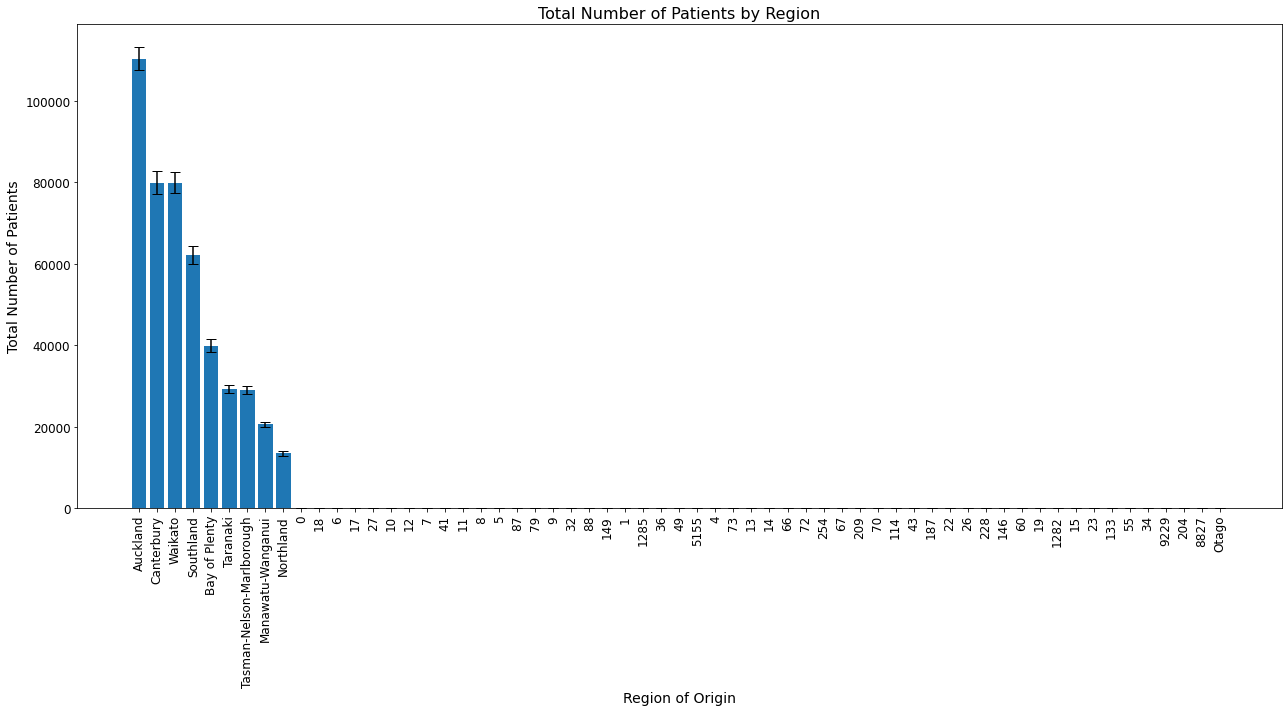

In [14]:
from pyspark.sql.functions import col, sum as _sum, mean as _mean, stddev as _stddev
import matplotlib.pyplot as plt

# Fill any missing values in 'amount' with zero
clients_data = clients_data.na.fill(0, subset=['amount'])

# Group by region and aggregate the total number of patients
region_data = clients_data.groupBy('Region').agg(
    _sum('amount').alias('Total_Patients'),
    _mean('amount').alias('Mean_Patients'),
    _stddev('amount').alias('Std_Dev_Patients')
)

# Convert to Pandas DataFrame for plotting
region_data_pd = region_data.toPandas()

# Replace NaN values in the resulting Pandas DataFrame with zero
region_data_pd = region_data_pd.fillna(0)

# Sort the data by total number of patients for better visualization
region_data_pd = region_data_pd.sort_values('Total_Patients', ascending=False)

# Plot the bar chart with correct region names
plt.figure(figsize=(18, 10))
bars = plt.bar(region_data_pd['Region'], region_data_pd['Total_Patients'], yerr=region_data_pd['Std_Dev_Patients'], capsize=5)
plt.xlabel('Region of Origin', fontsize=14)
plt.ylabel('Total Number of Patients', fontsize=14)
plt.title('Total Number of Patients by Region', fontsize=16)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, sum as _sum

# Fill any missing values in 'Total_Beds' with zero
hospital = hospital.na.fill(0, subset=['Total_Beds'])

# Group by region and aggregate the total number of beds
region_beds_data = hospital.groupBy('Region').agg(
    _sum('Total_Beds').alias('Total_Beds')
)

# Convert to Pandas DataFrame for plotting
region_beds_data_pd = region_beds_data.toPandas()

# Sort the data by total number of beds for better visualization
region_beds_data_pd = region_beds_data_pd.sort_values('Total_Beds', ascending=False)

# Plot the bar chart with correct region names
plt.figure(figsize=(18, 10))
bars = plt.bar(region_beds_data_pd['Region'], region_beds_data_pd['Total_Beds'])
plt.xlabel('Region', fontsize=14)
plt.ylabel('Total Hospital Beds', fontsize=14)
plt.title('Total Hospital Beds by Region', fontsize=16)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, sum as _sum

# Load the CSV data for hospital distribution
hospital = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("hospital distribution.csv")

# Fill any missing values in 'Total_Beds' with zero
hospital = hospital.na.fill(0, subset=['Total_Beds'])

# Group by region and aggregate the total number of beds
region_beds_data = hospital.groupBy('Region').agg(
    _sum('Total_Beds').alias('Total_Beds')
)

# Convert to Pandas DataFrame for plotting
region_beds_data_pd = region_beds_data.toPandas()

# Sort the data by total number of beds for better visualization
region_beds_data_pd = region_beds_data_pd.sort_values('Total_Beds', ascending=False)

# Plot the bar chart with correct region names
plt.figure(figsize=(18, 10))
bars = plt.bar(region_beds_data_pd['Region'], region_beds_data_pd['Total_Beds'])
plt.xlabel('Region', fontsize=14)
plt.ylabel('Total Hospital Beds', fontsize=14)
plt.title('Total Hospital Beds by Region', fontsize=16)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()
